## Prerequisites

- Block ciphers pdf
- Stream ciphers
- Types of attacks (CPA, CCA, KPA, etc)

# Theory

## Refresher

**Block cipher**
- A block cipher operates on "blocks" of data (128b). They transform blocks of data into blocks of the same size under a *key*.
- Important parameters
    - Block size $b$
    - Key size $k$
 
**Confusion and diffusion**
- https://en.wikipedia.org/wiki/Confusion_and_diffusion - a block cipher must provide both
- **Confusion**: The ciphertext statistics should depend on the plaintext statistics in a manner too complicated to be exploited by the cryptanalyst.
- **Diffusion**: Each digit of the plaintext and each digit of the secret key should influencemany digits of the ciphertext


**Difficulty of attack**
- Time - How much time is needed to break a block cipher
- Memory - How much memory is needed (usually a time-memory tradeoff exists)
- Data - How much data we need (ciphertexts, ciphertexts-plaintext pairs, etc)

Usually we want to search for the key => we want around $2^k$ operations needed to break it

## Design

Designing a block cipher requires specifying a **round function** and a **key schedule**

**The Key schedule**
> Let $K$ be a secret key. $K$ can be used to derive $N$ **round keys** ($K^1, ..., K^N$)

**The round function**
> Let $w^{r-1}$ be the current state of round $r-1$
> The round function $g$ takes the current state $w^{r-1}$ and a round key $K^r$ and produces $w^r$
$$w^r = g(w^{r-1}, K^r)$$

**Remark**
- for decryption to be possible $g$ must be injective. We want a function $g^{-1}$ with $g^{-1}(g(w, k), k) = w$

### Substitution Permutation Network (SPN)

- https://www.youtube.com/watch?v=DLjzI5dX8jc - computerphile video

Let 
- $l, m \in \mathbb{Z}_+$. $l\cdot m$ is the block length of the cipher $ \iff \mathcal{M} = \mathcal{C} = \{0, 1\}^{lm}$
- $\pi_S: \{0, 1\}^l \to \{0, 1\}^l$
    - $\pi_S$ = **S-box** = substitution box = replace $l$ bits with a different set of $l$ bits
    - Provides **confusion**
- $\pi_P: \{1, ... l\cdot m\} \to \{1, ..., l \cdot m \}$
    - $\pi_P$: permutation = change order of the $lm$ bits
    - Provides **diffusion**

The SPN has $N$ rounds. Except for the last round we will perform substitution $\to$ permutation $\to$ add key

**Note**
- The Sbox and Pbox don't provide security since they are easily reversible. They are linear operations too
- The xor with the secret key is what provides security

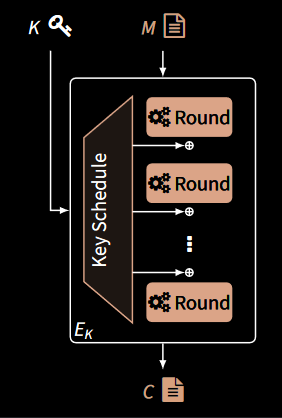
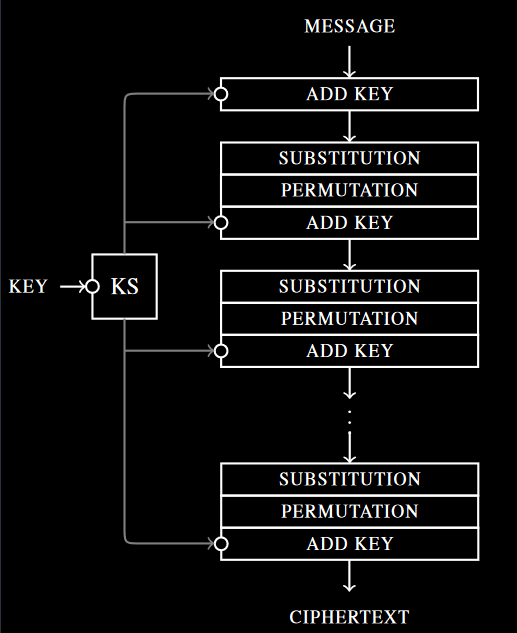

# Example from Cryptography - Theory and practice

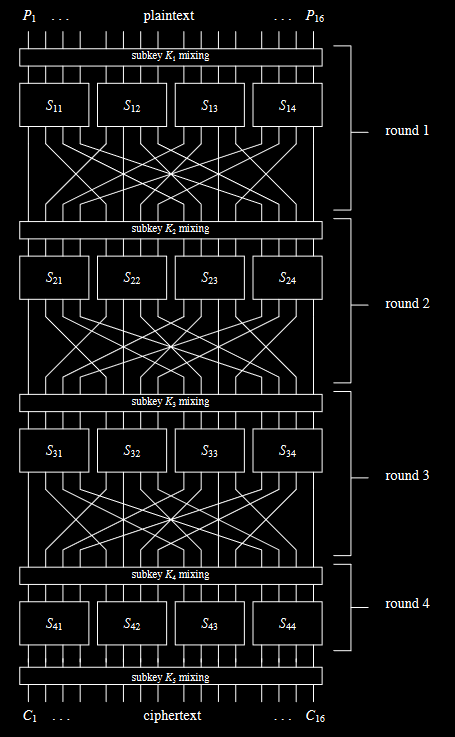

For the coding part we will consider the following:
- Bit indexing starts from left to right

In [55]:
# Helper functions

def bit_parity(x):
    '''
    Bit parity of a number
    '''
    t = 0
    while(x != 0):
        t  = t ^ (x & 1)
        x >>= 1
    return t


def get_bit(x, i, n):
    '''
    n = 5
    x = 0 1 0 1 0 
    i = 0 1 2 3 4
    '''
    return (x >> (n - 1 - i)) & 1


def set_bit(x, i, n, b):
    '''
    sets the `i`th bit to `b`
    '''
    if b == 1:
        return x | (1 << (n - 1 - i))
    else:
        return x &  ~int((1 << (n - 1 - i)))
    
def inverse_sbox(S):
    """
    Input:
    S: {list} -- sbox
    Return
    {list} -- the inverse of the sbox
    """
    S_ = [-1] * len(S)
    for i, entry in enumerate(S):
        S_[entry] = i
    return S_
    


In [19]:
# Substitute and permute

def substitute(x, sbox, l):
    """
    Takes a 2**n bit number x and substitutes n-bit parts according to the n-bit sbox
    Arguments
        x: {int} --  input number of size 2**n bits
        sbox: {Sbox} -- Sbox with input entries of size n bits
        l: {int} -- Sbox input size in bits
    Returns 
        {int} -- output sboxed
    """
    word_size = 1 << l
    mask = (1<<l) - 1
    y = 0
    for i in range(0, word_size, l): # Steps of n-bits
        y  = y << l # Shift 'l' positions to make space for l-bit sbox number
        idx = (x >> (word_size - i - l)) & mask # Get n-bit index in the sbox
        y = y | sbox[idx] # "append" the bit from x
    return y
        
        
def permute(x, pbox, n):
    """
    Takes a n-bit int x and permutes the bits from it according to the pbox
    Arguments
        x: {int}  -- n-bit int
        pbox: {list} -- list of integers of length n
    Return: 
        {int}
    """
    y = 0
    for p in pbox:
        y = y << 1 # shift to make space for LSB 
        y = y ^ get_bit(x, p, n) # "append" the p'th bit from x
    return y
        

In [20]:
#Examples
print(bit_parity(0b1010)) # 0
print(get_bit(0b1010, 1, 4)) # left to right
print(set_bit(0b1010, i=1, n=4, b=1)) # 1110
print(set_bit(0b1010, i=2, n=4, b=0)) # 1000


0
0
14
8


In [21]:
K = 0b0011_1010_1001_0100_1101_0110_0011_1111

In [22]:
K = 0b0011_1010_1001_0100_1101_0110_0011_1111
Ks = [int(bin(K)[2:].zfill(32)[4 * r: 4 * r + 16], 2) for r in range(5)] # Generate some keys

print([bin(Ki)[2:].zfill(16) for Ki in Ks])
m = 0b0010_0110_1011_0111 # message

['0011101010010100', '1010100101001101', '1001010011010110', '0100110101100011', '1101011000111111']


 | | | | | | | | | | | | | | | | | |
- | -| -| -| -| -| -| -| -| -| -| -| -| -| -| -| -
z | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9| A| B| C| D| E| F| 
π_S(z)| E| 4| D| 1| 2| F| B| 8| 3| A| 6| C| 5| 9| 0| 7

 | | | | | | | | | | | | | | | | | |
- | -| -| -| -| -| -| -| -| -| -| -| -| -| -| -| -
z | 0| 1| 2| 3| 4| 5| 6| 7| 8| 9| A| B| C| D| E| F| 
π_p(z)| 0|4|8|12|1|5|9|13|2|6|10|14|3|7|11|15

In [25]:
#Sbox and Pbox
S = [14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7]
print(S)
P = [0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15]
print(P)

[14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7]
[0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15]


In [26]:
hex(substitute(0x0123, S, 4)) # 0e4d1

'0xe4d1'

In [29]:
def spn_network(m, K, S, P, n = 4, word_size = 16, verbose = False):
    
    # Derive round keys
    Ks = [K >> i * 4 & 0xffff for i in range(4, -1, -1)]
    
    w = m
    for i in range(len(Ks) - 2):
        u = w ^ Ks[i]
        v = substitute(u, S, n)
        w = permute(v, P, word_size)
        
        if verbose == True:
            print(f"K{i}: ", bin(Ks[i])[2:].zfill(16))
            print(f"u{i}: ", bin(w)[2:].zfill(16))
            print(f"v{i}: ", bin(v)[2:].zfill(16))
            print(f"w{i}: ", bin(w)[2:].zfill(16))
        
    u = w ^ Ks[-2] 
    v = substitute(u, S, n)
    y = v ^ Ks[-1]
    
    if verbose == True:
        print(f"K{i+1}: ", bin(Ks[i+1])[2:].zfill(16))
        print(f"u{i+1}: ", bin(u)[2:].zfill(16))
        print(f"v{i+1}: ", bin(v)[2:].zfill(16))
        print(f"K{i+2}: ", bin(Ks[i+2])[2:].zfill(16))
    return y

In [52]:
spn_network(m, K, S, P, verbose=True)

K0:  0011101010010100
u0:  0010111000000111
v0:  0100010111010001
w0:  0010111000000111
K1:  1010100101001101
u1:  0100000110111000
v1:  0011100000100110
w1:  0100000110111000
K2:  1001010011010110
u2:  1110010001101110
v2:  1001111110110000
w2:  1110010001101110
K3:  0100110101100011
u3:  1010100100001101
v3:  0110101011101001
K4:  1101011000111111


48342

### Let's put it in a class to look better

In [69]:
class SPN:
    def __init__(self, sbox, pbox, block_size = 16, sbox_input_size = 4):
        self.sbox = sbox
        self.sbox_ = inverse_sbox(sbox)
        self.pbox = pbox
        self.block_size = block_size
        self.l = sbox_input_size
        
    def key_schedule(self, k):
        return [k >> i * 4 & 0xffff for i in range(4, -1, -1)]

    def encrypt(self, m: int, k: int) -> int:
        ks = self.key_schedule(k)
        
        w = m
        for i in range(len(ks) - 2):
            u = w ^ ks[i]
            v = substitute(u, self.sbox, self.l)
            w = permute(v, self.pbox, self.block_size)
            
        u = w ^ ks[-2] 
        v = substitute(u, S, self.l)
        y = v ^ ks[-1]
        
        return y
    
    
    def decrypt(self, c: int, k: int) -> int:
        
        ks = self.key_schedule(k)
        
        v = ks[-1] ^ c
        u = substitute(v, self.sbox_, self.l)
        w = ks[-2] ^ u
        
        for ki in ks[::-1][2:]:
            v = permute(w, self.pbox, self.block_size)
            u = substitute(v, self.sbox_, self.l)
            w = u ^ ki
        return w
        

In [70]:
K = 0b0011_1010_1001_0100_1101_0110_0011_1111
m = 0b0010_0110_1011_0111 # message

spn = SPN(S, P)
c = spn.encrypt(m, K)
print(c)

48342


In [73]:
m == spn.decrypt(c, K)

True

## ARX ciphers

- https://www.youtube.com/watch?v=UeIpq-C-GSA - ChaCha example
- https://crypto.polito.it/content/download/480/2850/file/document.pdf
- https://crypto.stackexchange.com/questions/51412/weaknesses-in-arx-block-ciphers


ARX comes from
- **Add** - modular addition ($\bmod 2^n$)
- **Rotation** - circular shift https://en.wikipedia.org/wiki/Circular_shift
- **XOR** 

Pros 
- Fast on PC
- easy and compact implementations
- no timing attacks

Cons
- Bad in hardware (hard to optimize)
- Unclear security guarantees
- May be weak against side-channel hardware attacks

For code check out the ChaCha implementation in the Stream cipher section

# Resources

- Block cipher companion
- Cryptography - theory and practice
- https://www.iaik.tugraz.at/course/cryptanalysis-705068-sommersemester-2021/ - some figures are from here